# 高通滤波器（HPF）
根据像素与周围像素的亮度差值来提升（boost）该像素的亮度

## 低通滤波器（LPF）
在像素与周围像素的亮度差值小于一个特定值时，平滑该像素的亮度，主要作用是去噪和模糊化。高斯模糊是最常用的模糊滤波器（平滑滤波器），作用是削弱高频信号的强度。

In [1]:
import cv2
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from helper import *
%matplotlib inline

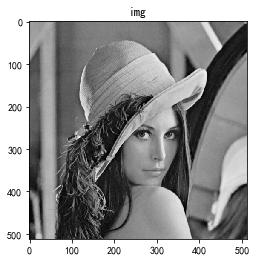

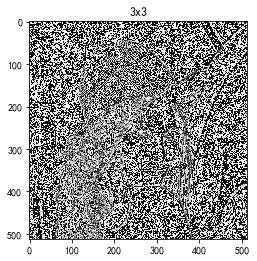

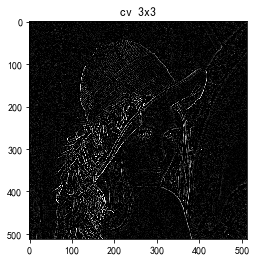

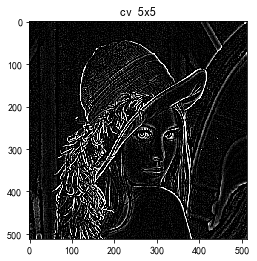

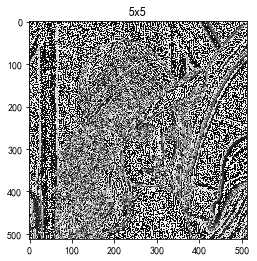

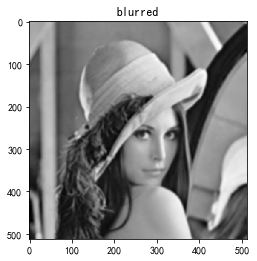

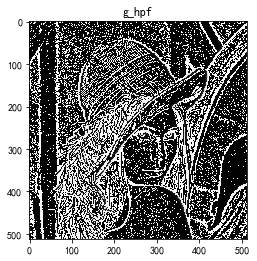

In [8]:
# 为什么滤波器的值加起来都是 0?为什么用这些值？
kernel_3x3 = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
])

kernel_5x5 = np.array([
    [-1, -1, -1, -1, -1],
    [-1, 1, 2, 1, -1],
    [-1, 2, 4, 2, -1],
    [-1, 1, 2, 1, -1],
    [-1, -1, -1, -1, -1]
])

img = cv2.imread('./images/lena.png', 0)
k3 = ndimage.convolve(img, kernel_3x3)
k5 = ndimage.convolve(img, kernel_5x5)

cvk3 = cv2.filter2D(img, -1, kernel_3x3)
cvk5 = cv2.filter2D(img, -1, kernel_5x5)

blurred = cv2.GaussianBlur(img, (11,11), 0)
# 原始图像减去低通滤波的结果
g_hpf = img - blurred

showGray(img, "img")
showGray(k3, "3x3")
showGray(cvk3, "cv 3x3")
showGray(cvk5, "cv 5x5")
showGray(k5, "5x5")
showGray(blurred, "blurred")
showGray(g_hpf, "g_hpf")

## 边缘检测
- Laplacian()
- Sobel()
- Scharr()
- Canny()

非边缘区域转化为黑色，边缘区域转化为白色，直接处理图像会讲噪声识别为边缘，通常会先进行模糊处理

- blur()：算术平均
- medianBlur()
- GaussianBlur()


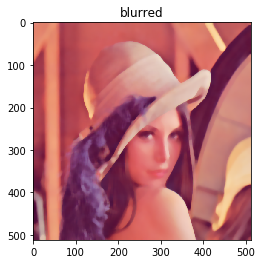

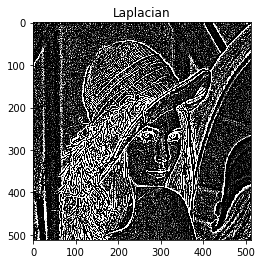

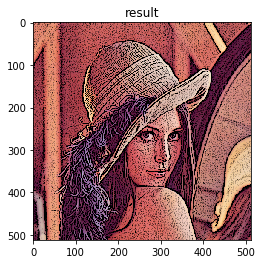

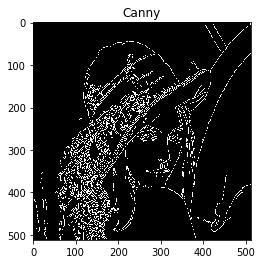

In [40]:
img = cv2.imread('./images/lena.png')
blurKsize = 11
edgeKsize = 5
blurred = cv2.medianBlur(img, blurKsize)
grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
laplacianImg = cv2.Laplacian(grayImg, cv2.CV_8U, ksize=edgeKsize)
cannyImg = cv2.Canny(grayImg, 50, 200, 3)

# 把边缘检测的结果以黑色的形式画到原图上
normalizedInverseAlpha = (1.0 / 255) * (255 - laplacianImg)
channels = cv2.split(img)
for channel in channels:
    channel[:] = channel * normalizedInverseAlpha
dst = cv2.merge(channels)

showBGR(blurred, "blurred")
showGray(laplacianImg, "Laplacian")
showBGR(dst, "result")

showGray(cannyImg, "Canny")

## 核（卷积矩阵）
核就是一组权重，决定了如何通过相邻像素点来计算新的像素点，`filter2D` 这个函数是一个通用的使用自定义卷积核的函数

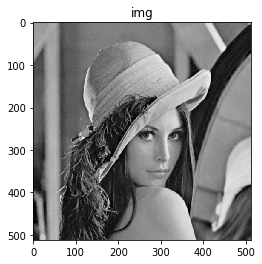

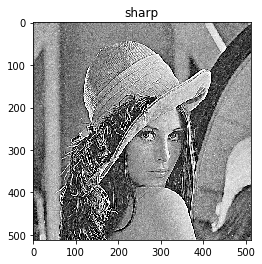

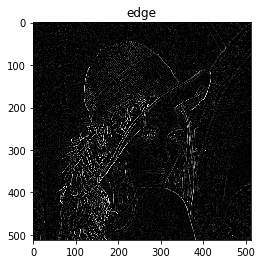

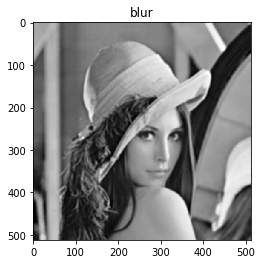

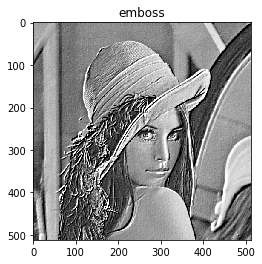

In [41]:
# 锐化滤波器，当前像素值乘以 9，然后减去 8 个临近像素值，
# 如果目标像素值已经和临近的像素有一点差别，这个差别会被放大。
sharp_kernel = np.array([
    [-1, -1, -1],
    [-1, 9, -1],
    [-1, -1, -1]
])

edge_kernel = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
])

# 临近平均滤波器，权重和为 1
blur_kernel = np.array([
    [0.04, 0.04, 0.04, 0.04, 0.04],
    [0.04, 0.04, 0.04, 0.04, 0.04],
    [0.04, 0.04, 0.04, 0.04, 0.04],
    [0.04, 0.04, 0.04, 0.04, 0.04],
    [0.04, 0.04, 0.04, 0.04, 0.04]
])

# 浮雕滤波器 embossed
emboss_kernal = np.array([
    [-2, -1, 0],
    [-1,  1, 1],
    [ 0,  1, 2]
])

img = cv2.imread('./images/lena.png', 0)
sharped_dst = cv2.filter2D(img, -1, sharp_kernel)
edge_dst = cv2.filter2D(img, -1, edge_kernel)
blur_dst = cv2.filter2D(img, -1, blur_kernel)
emboss_dst = cv2.filter2D(img, -1, emboss_kernal)

showGray(img, "img")
showGray(sharped_dst, "sharp")
showGray(edge_dst, "edge")
showGray(blur_dst, "blur")
showGray(emboss_dst, "emboss")

## 边界框、最小矩形和最小闭圆

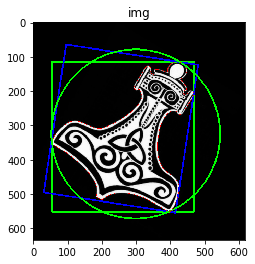

In [51]:
import cv2
import numpy as np

img = cv2.pyrDown(cv2.imread("./images/hammer.jpg", cv2.IMREAD_UNCHANGED))

ret, thresh = cv2.threshold(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY), 127, 255, cv2.THRESH_BINARY)

# RETR_EXTERNAL 消除包含在其他轮廓中的轮廓
image, contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for c in contours:
    # bounding box
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 3)
    
    # 面积最小矩形
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int32(box)
    cv2.drawContours(img, [box], 0, (0,0,255), 3)
    
    # 最小闭圆
    (x,y), radius = cv2.minEnclosingCircle(c)
    center = (int(x), int(y))
    radius = int(radius)
    img = cv2.circle(img, center, radius, (0,255,0), 3)

cv2.drawContours(img, contours, -1, (255,0,0), 1)
showGray(img, "img")

## 凸轮廓
定义：凸形状内部的任意两点的连线都在该形状里面

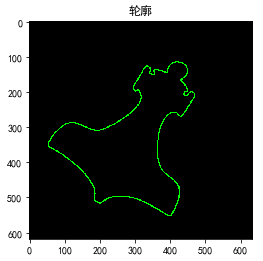

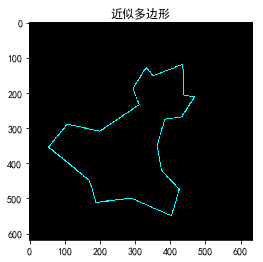

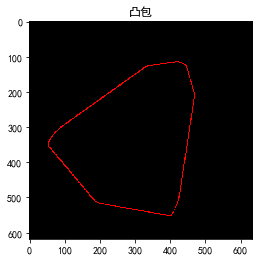

In [2]:
import cv2
import numpy as np
from helper import *
%matplotlib inline

img = cv2.pyrDown(cv2.imread("./images/hammer.jpg", cv2.IMREAD_UNCHANGED))

ret, thresh = cv2.threshold(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY), 127, 255, cv2.THRESH_BINARY)

cnt_black = cv2.cvtColor(np.zeros((img.shape[1], img.shape[0]), dtype=np.uint8), cv2.COLOR_GRAY2BGR)
approx_black = cv2.cvtColor(np.zeros((img.shape[1], img.shape[0]), dtype=np.uint8), cv2.COLOR_GRAY2BGR)
hull_black = cv2.cvtColor(np.zeros((img.shape[1], img.shape[0]), dtype=np.uint8), cv2.COLOR_GRAY2BGR)

image, contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    # epsilon 越小，拟合出的多边形越准确
    epsilon = 0.01 * cv2.arcLength(cnt,True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    
    hull = cv2.convexHull(cnt)
    cv2.drawContours(cnt_black, [cnt], -1, (0, 255, 0), 2)
    cv2.drawContours(approx_black, [approx], -1, (255, 255, 0), 2)
    cv2.drawContours(hull_black, [hull], -1, (0, 0, 255), 2)

showBGR(cnt_black, "轮廓")
showBGR(approx_black, "近似多边形")
showBGR(hull_black, "凸包")

## 直线和圆检测
Hough 变换是形状检测的基础，霍夫变换可以理解为投票箱和投票数之间的关系，每个投票箱代表一个直线，投票数达到阈值的直线会被保留

直线检测
- HoughLines: 标准霍夫变换
- HoughLinesP：使用概率霍夫变换，运行速度会快一些



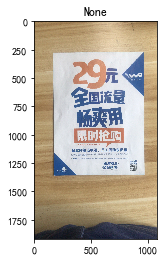

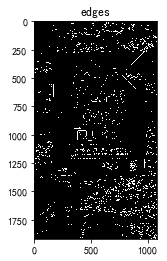

<Figure size 864x1728 with 0 Axes>

In [2]:
img = cv2.imread('./images/lines.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 0, 50)

# # 直线长度小于 20 的会被忽略
# minLineLength = 20

# # 一条线段的间隙长度大于这个值会认为是两条分开的线
# maxLineGap = 20

# lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50, minLineLength, maxLineGap)

# print("Lines: %d" % len(lines[0]))
# for x1,y1,x2,y2 in lines[0]:
#     cv2.line(img, (x1,y1), (x2,y2), (0,255,0), 2)

showBGR(img, "lines")
showGray(edges, "edges", (12, 24))